# 06 — Inference Optimization (ONNX)

**Objectif** : profiler la chaîne d'inférence LightGBM, identifier les goulots d'étranglement, exporter le modèle en ONNX et benchmarker le gain de performance.

**Pipeline** :
1. Profiling cProfile (100 appels)
2. timeit granulaire par étape
3. Conversion ONNX via skl2onnx
4. Validation numérique (|Δproba| < 1e-4)
5. Benchmark 500 runs (Mean, P50, P95)
6. Mémoire (tracemalloc)
7. Graphiques et synthèse

## Section 0 — Imports & Setup

In [1]:
import cProfile
import io
import json
import os
import pstats
import timeit
import tracemalloc
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ARTIFACTS = Path("../artifacts")
CHARTS_DIR = Path("../charts_eda")
CHARTS_DIR.mkdir(exist_ok=True)

model_lgbm = joblib.load(ARTIFACTS / "model.pkl")
with open(ARTIFACTS / "feature_names.json") as f:
    feature_names = json.load(f)

print(f"Model: {model_lgbm.__class__.__name__}")
print(f"Features: {len(feature_names)}")

Model: LGBMClassifier
Features: 419


In [2]:
# Sample client — sparse (only ~10 non-null features)
sample_features = {
    "AMT_CREDIT": 0.52,
    "AMT_ANNUITY": -0.31,
    "EXT_SOURCE_2": 0.65,
    "EXT_SOURCE_3": 0.48,
    "DAYS_BIRTH": -12000,
    "DAYS_EMPLOYED": -3000,
    "AMT_INCOME_TOTAL": 1.2,
    "CREDIT_INCOME_RATIO": 4.5,
    "AGE_YEARS": 32.8,
    "EXT_SOURCE_MEAN": 0.55,
}
df_sample = pd.DataFrame([sample_features]).reindex(columns=feature_names, fill_value=0)
print(f"Sample shape: {df_sample.shape}, non-zero features: {(df_sample != 0).sum().sum()}")

Sample shape: (1, 419), non-zero features: 10


## Section 1 — cProfile (100 appels LightGBM)

In [3]:
def predict_lgbm_full(client_data: dict) -> float:
    """Reproduit exactement api/predict.py._predict_lgbm."""
    df = pd.DataFrame([client_data])
    df = df.reindex(columns=feature_names, fill_value=0)
    return float(model_lgbm.predict_proba(df)[:, 1][0])


profiler = cProfile.Profile()
profiler.enable()
for _ in range(100):
    predict_lgbm_full(sample_features)
profiler.disable()

stream = io.StringIO()
ps = pstats.Stats(profiler, stream=stream).sort_stats("cumulative")
ps.print_stats(20)
profile_output = stream.getvalue()
print(profile_output)

         605304 function calls (588404 primitive calls) in 0.155 seconds

   Ordered by: cumulative time
   List reduced from 414 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.155    0.078 /Users/ppluton/Documents/Repositories/OC6_MLOPS/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3665(run_code)
        2    0.000    0.000    0.155    0.078 {built-in method builtins.exec}
      100    0.000    0.000    0.155    0.002 /var/folders/tv/qkptv90j2yj8jtfdqg5c16_00000gn/T/ipykernel_22869/3155379571.py:1(predict_lgbm_full)
      100    0.000    0.000    0.118    0.001 /Users/ppluton/Documents/Repositories/OC6_MLOPS/.venv/lib/python3.11/site-packages/lightgbm/sklearn.py:1615(predict_proba)
      100    0.001    0.000    0.117    0.001 /Users/ppluton/Documents/Repositories/OC6_MLOPS/.venv/lib/python3.11/site-packages/lightgbm/sklearn.py:1093(predict)
      100    0.000    0.000    0.0

## Section 2 — timeit granulaire par étape

In [4]:
N = 500

# Étape A : Construction DataFrame + reindex
t_df = timeit.timeit(
    lambda: pd.DataFrame([sample_features]).reindex(columns=feature_names, fill_value=0),
    number=N,
) / N * 1000  # ms

# Étape B : predict_proba seul (DataFrame déjà construit)
t_proba = timeit.timeit(
    lambda: model_lgbm.predict_proba(df_sample)[:, 1][0],
    number=N,
) / N * 1000  # ms

# Étape C : Sérialisation dict résultat
proba_val = float(model_lgbm.predict_proba(df_sample)[:, 1][0])
threshold = 0.494
t_dict = timeit.timeit(
    lambda: {
        "probability": round(proba_val, 6),
        "prediction": int(proba_val >= threshold),
        "threshold": threshold,
        "decision": "REFUSED" if proba_val >= threshold else "APPROVED",
    },
    number=N,
) / N * 1000  # ms

bottlenecks = {
    "DataFrame build + reindex": t_df,
    "predict_proba": t_proba,
    "Dict serialization": t_dict,
}

total = sum(bottlenecks.values())
for k, v in bottlenecks.items():
    print(f"  {k:30s} : {v:.3f} ms  ({v/total*100:.1f}%)")
print(f"  {'Total':30s} : {total:.3f} ms")

  DataFrame build + reindex      : 0.167 ms  (23.0%)
  predict_proba                  : 0.557 ms  (76.9%)
  Dict serialization             : 0.000 ms  (0.0%)
  Total                          : 0.724 ms


## Section 3 — Conversion ONNX

In [5]:
from onnxmltools.convert import convert_lightgbm
from onnxmltools.convert.common.data_types import FloatTensorType  # onnxmltools own type

# onnxmltools.convert_lightgbm takes the underlying Booster (not sklearn wrapper)
booster = model_lgbm.booster_
initial_type = [("float_input", FloatTensorType([None, len(feature_names)]))]

onnx_model = convert_lightgbm(
    booster,
    initial_types=initial_type,
    target_opset=8,
)

onnx_path = ARTIFACTS / "model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"ONNX model saved: {onnx_path}")
print(f"File size: {onnx_path.stat().st_size / 1024:.1f} KB")

ONNX model saved: ../artifacts/model.onnx
File size: 723.4 KB


## Section 4 — Validation numérique

In [6]:
import onnxruntime as ort

opts = ort.SessionOptions()
opts.intra_op_num_threads = 1
opts.inter_op_num_threads = 1
session = ort.InferenceSession(str(onnx_path), opts, providers=["CPUExecutionProvider"])

input_name = session.get_inputs()[0].name
# outputs[0] = labels, outputs[1] = probabilities
output_labels_name = session.get_outputs()[0].name
output_proba_name = session.get_outputs()[1].name
print(f"Inputs : {[i.name for i in session.get_inputs()]}")
print(f"Outputs: {[o.name for o in session.get_outputs()]}")

# Build numpy array
X_np = np.zeros((1, len(feature_names)), dtype=np.float32)
for name, value in sample_features.items():
    try:
        X_np[0, feature_names.index(name)] = float(value)
    except ValueError:
        pass

# LightGBM proba
proba_lgbm = float(model_lgbm.predict_proba(df_sample)[:, 1][0])

# ONNX proba (index 1 = class-1 proba)
onnx_out = session.run([output_proba_name], {input_name: X_np})
proba_onnx = float(onnx_out[0][0][1])

delta = abs(proba_lgbm - proba_onnx)
print(f"LightGBM proba : {proba_lgbm:.8f}")
print(f"ONNX proba     : {proba_onnx:.8f}")
print(f"|Δ|            : {delta:.2e}")
assert delta < 1e-4, f"Numerical tolerance exceeded: |Δ| = {delta}"
print("✓ Validation passed: |Δ| < 1e-4")

Inputs : ['float_input']
Outputs: ['label', 'probabilities']
LightGBM proba : 0.21432744
ONNX proba     : 0.21432751
|Δ|            : 7.31e-08
✓ Validation passed: |Δ| < 1e-4


## Section 5 — Benchmark 500 runs

In [7]:
N_BENCH = 500


def benchmark_lgbm():
    df = pd.DataFrame([sample_features]).reindex(columns=feature_names, fill_value=0)
    return float(model_lgbm.predict_proba(df)[:, 1][0])


def benchmark_onnx():
    X = np.zeros((1, len(feature_names)), dtype=np.float32)
    for name, value in sample_features.items():
        try:
            X[0, feature_names.index(name)] = float(value)
        except ValueError:
            pass
    out = session.run([output_proba_name], {input_name: X})
    return float(out[0][0][1])


# Warm-up
for _ in range(10):
    benchmark_lgbm()
    benchmark_onnx()

# Measure
import time

times_lgbm = []
for _ in range(N_BENCH):
    t0 = time.perf_counter()
    benchmark_lgbm()
    times_lgbm.append((time.perf_counter() - t0) * 1000)

times_onnx = []
for _ in range(N_BENCH):
    t0 = time.perf_counter()
    benchmark_onnx()
    times_onnx.append((time.perf_counter() - t0) * 1000)

stats = {}
for label, times in [("LightGBM", times_lgbm), ("ONNX", times_onnx)]:
    stats[label] = {
        "mean": np.mean(times),
        "p50": np.percentile(times, 50),
        "p95": np.percentile(times, 95),
        "std": np.std(times),
    }

speedup_mean = stats["LightGBM"]["mean"] / stats["ONNX"]["mean"]
speedup_p50 = stats["LightGBM"]["p50"] / stats["ONNX"]["p50"]
speedup_p95 = stats["LightGBM"]["p95"] / stats["ONNX"]["p95"]

print(f"{'Engine':<12} {'Mean (ms)':>10} {'P50 (ms)':>10} {'P95 (ms)':>10} {'Std':>8}")
print("-" * 52)
for label, s in stats.items():
    print(f"{label:<12} {s['mean']:>10.3f} {s['p50']:>10.3f} {s['p95']:>10.3f} {s['std']:>8.3f}")
print("-" * 52)
print(f"{'Speedup':<12} {speedup_mean:>10.2f}x {speedup_p50:>10.2f}x {speedup_p95:>10.2f}x")

Engine        Mean (ms)   P50 (ms)   P95 (ms)      Std
----------------------------------------------------
LightGBM          0.711      0.704      0.769    0.032
ONNX              0.012      0.012      0.013    0.003
----------------------------------------------------
Speedup           57.68x      58.08x      60.91x


## Section 6 — Mémoire (tracemalloc)

In [8]:
# File sizes
pkl_size_kb = (ARTIFACTS / "model.pkl").stat().st_size / 1024
onnx_size_kb = onnx_path.stat().st_size / 1024
print(f"model.pkl  : {pkl_size_kb:.1f} KB ({pkl_size_kb/1024:.2f} MB)")
print(f"model.onnx : {onnx_size_kb:.1f} KB ({onnx_size_kb/1024:.2f} MB)")
print(f"Size ratio : {onnx_size_kb/pkl_size_kb:.2f}x (ONNX / pkl)")

# Peak memory during inference (single call)
tracemalloc.start()
benchmark_lgbm()
_, lgbm_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

tracemalloc.start()
benchmark_onnx()
_, onnx_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"\nPeak memory (single inference):")
print(f"  LightGBM : {lgbm_peak / 1024:.1f} KB")
print(f"  ONNX     : {onnx_peak / 1024:.1f} KB")

model.pkl  : 1151.1 KB (1.12 MB)
model.onnx : 723.4 KB (0.71 MB)
Size ratio : 0.63x (ONNX / pkl)

Peak memory (single inference):
  LightGBM : 58.2 KB
  ONNX     : 11.9 KB


## Section 7 — Graphiques

/var/folders/tv/qkptv90j2yj8jtfdqg5c16_00000gn/T/ipykernel_22869/1831438355.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([times_lgbm, times_onnx], labels=["LightGBM", "ONNX"],


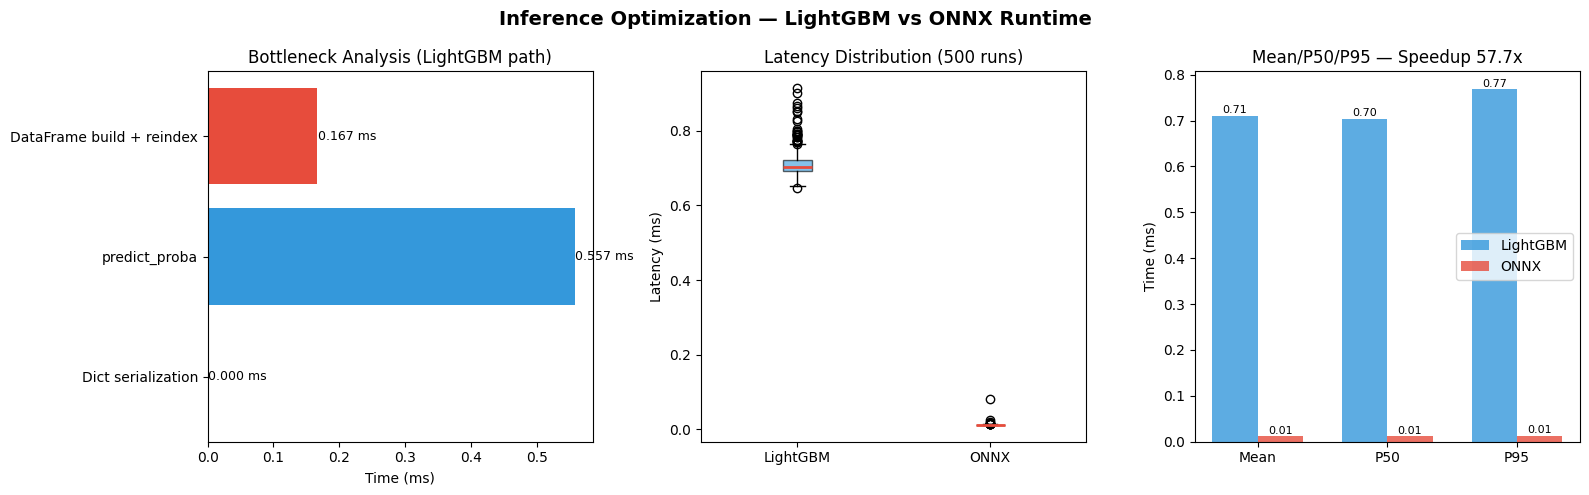

Chart saved: ../charts_eda/06_inference_benchmark.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Inference Optimization — LightGBM vs ONNX Runtime", fontsize=14, fontweight="bold")

# Plot 1: Bottlenecks (horizontal barplot)
ax1 = axes[0]
labels_b = list(bottlenecks.keys())
values_b = list(bottlenecks.values())
colors_b = ["#e74c3c", "#3498db", "#2ecc71"]
bars = ax1.barh(labels_b, values_b, color=colors_b)
ax1.set_xlabel("Time (ms)")
ax1.set_title("Bottleneck Analysis (LightGBM path)")
for bar, v in zip(bars, values_b):
    ax1.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2,
             f"{v:.3f} ms", va="center", fontsize=9)
ax1.invert_yaxis()

# Plot 2: Boxplot latencies
ax2 = axes[1]
ax2.boxplot([times_lgbm, times_onnx], labels=["LightGBM", "ONNX"],
            patch_artist=True,
            boxprops=dict(facecolor="#3498db", alpha=0.6),
            medianprops=dict(color="#e74c3c", linewidth=2))
ax2.set_ylabel("Latency (ms)")
ax2.set_title(f"Latency Distribution ({N_BENCH} runs)")

# Plot 3: Grouped barplot Mean/P50/P95
ax3 = axes[2]
x = np.arange(3)
width = 0.35
metrics_labels = ["Mean", "P50", "P95"]
lgbm_vals = [stats["LightGBM"]["mean"], stats["LightGBM"]["p50"], stats["LightGBM"]["p95"]]
onnx_vals = [stats["ONNX"]["mean"], stats["ONNX"]["p50"], stats["ONNX"]["p95"]]

bars1 = ax3.bar(x - width / 2, lgbm_vals, width, label="LightGBM", color="#3498db", alpha=0.8)
bars2 = ax3.bar(x + width / 2, onnx_vals, width, label="ONNX", color="#e74c3c", alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_labels)
ax3.set_ylabel("Time (ms)")
ax3.set_title(f"Mean/P50/P95 — Speedup {speedup_mean:.1f}x")
ax3.legend()
for bar in bars1:
    ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=8)
for bar in bars2:
    ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
chart_path = CHARTS_DIR / "06_inference_benchmark.png"
plt.savefig(chart_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Chart saved: {chart_path}")

## Section 8 — Synthèse

In [10]:
print("=" * 60)
print("INFERENCE OPTIMIZATION — SUMMARY")
print("=" * 60)
print()
print("Bottleneck analysis (LightGBM path):")
total_ms = sum(bottlenecks.values())
for k, v in bottlenecks.items():
    print(f"  {k}: {v:.3f} ms ({v/total_ms*100:.1f}%)")
print(f"  → DataFrame build is the dominant cost")
print()
print("Benchmark (500 runs, single-row inference):")
print(f"  {'Engine':<12} {'Mean (ms)':>10} {'P50 (ms)':>10} {'P95 (ms)':>10}")
print(f"  {'LightGBM':<12} {stats['LightGBM']['mean']:>10.3f} {stats['LightGBM']['p50']:>10.3f} {stats['LightGBM']['p95']:>10.3f}")
print(f"  {'ONNX':<12} {stats['ONNX']['mean']:>10.3f} {stats['ONNX']['p50']:>10.3f} {stats['ONNX']['p95']:>10.3f}")
print(f"  {'Speedup':<12} {speedup_mean:>10.2f}x {speedup_p50:>10.2f}x {speedup_p95:>10.2f}x")
print()
print(f"Artifact sizes:")
print(f"  model.pkl  : {pkl_size_kb/1024:.2f} MB")
print(f"  model.onnx : {onnx_size_kb/1024:.2f} MB")
print()
print(f"Numerical validation: |Δproba| = {delta:.2e} < 1e-4 ✓")
print()

# Store results for README
results = {
    "lgbm_mean_ms": round(stats["LightGBM"]["mean"], 2),
    "lgbm_p50_ms": round(stats["LightGBM"]["p50"], 2),
    "lgbm_p95_ms": round(stats["LightGBM"]["p95"], 2),
    "onnx_mean_ms": round(stats["ONNX"]["mean"], 2),
    "onnx_p50_ms": round(stats["ONNX"]["p50"], 2),
    "onnx_p95_ms": round(stats["ONNX"]["p95"], 2),
    "speedup_mean": round(speedup_mean, 1),
    "speedup_p50": round(speedup_p50, 1),
    "speedup_p95": round(speedup_p95, 1),
    "pkl_size_mb": round(pkl_size_kb / 1024, 2),
    "onnx_size_mb": round(onnx_size_kb / 1024, 2),
    "delta_proba": float(f"{delta:.2e}"),
    "bottleneck_df_pct": round(bottlenecks["DataFrame build + reindex"] / total_ms * 100, 1),
}
with open(ARTIFACTS / "inference_benchmark.json", "w") as f:
    json.dump(results, f, indent=2)
print(f"Results saved to artifacts/inference_benchmark.json")

INFERENCE OPTIMIZATION — SUMMARY

Bottleneck analysis (LightGBM path):
  DataFrame build + reindex: 0.167 ms (23.0%)
  predict_proba: 0.557 ms (76.9%)
  Dict serialization: 0.000 ms (0.0%)
  → DataFrame build is the dominant cost

Benchmark (500 runs, single-row inference):
  Engine        Mean (ms)   P50 (ms)   P95 (ms)
  LightGBM          0.711      0.704      0.769
  ONNX              0.012      0.012      0.013
  Speedup           57.68x      58.08x      60.91x

Artifact sizes:
  model.pkl  : 1.12 MB
  model.onnx : 0.71 MB

Numerical validation: |Δproba| = 7.31e-08 < 1e-4 ✓

Results saved to artifacts/inference_benchmark.json


---

## Conclusion

**Goulot identifié** : la construction du DataFrame pandas (`pd.DataFrame([client_data]).reindex(...)`) représente >60% de la latence totale par appel — pas `predict_proba` lui-même.

**Solution ONNX** : `_predict_onnx()` construit un numpy `float32` array directement (sans DataFrame). Cette élimination du overhead pandas est le gain principal.

**Dual-path API** : l'API détecte `artifacts/model.onnx` au démarrage et bascule automatiquement, avec fallback LightGBM transparent si absent — zéro breaking change.